# Applied Machine Learning: Mini Project 1 - Group 46

## Dataset 1: Adult Dataset

For the first part of the project, we begin our analysis on the provided Adult dataset. 
<br>Most of our helper functions can be found in the ***tools.py*** file.
<br>We start by importing the dataset and storing the equivalent data in Pandas Dataframes:

In [1]:
import pandas as pd
import numpy as np
import random
import tools
from sklearn.compose import make_column_selector as selector
from sklearn import preprocessing
from sklearn.preprocessing import normalize
import warnings
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
import sklearn

warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", sep=",")
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
              'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
              'label']
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Now, we try cleaning our data by dropping irrelevant features that could obstruct the performance of our model:

In [2]:
# dropping noising features
df = df.drop(columns=['fnlwgt','education'])

# replacing all invalid entries by NaN
df = tools.clean_df(df)

df

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


We dropped features that are irrelevant, and replaced any invalid entry by "NaN". Now we need to convert discrete variables into multiple variables by using one-hot encoding, provided by sklearn. We also need to replace all "NaN" entries by the mean of the column for continuous data, and by the mode of the column for discrete data.

In [3]:
labels = df.loc[:, 'label'].to_numpy() # array to label string
df = df.iloc[:, 0:-1] # drop label in dataframe
# do label encoding on Y
le = preprocessing.LabelEncoder()
le.fit(labels)
#print("classes = ", le.classes_)
Y = le.transform(labels)


# select the columns with discrete variables
discrete_columns_selector = selector(dtype_include=object)
discrete_columns = discrete_columns_selector(df)
df_discrete = df[discrete_columns]


# replacing nan values with mode of respective column
for (column_name, column_data) in df_discrete.iteritems():
    mode = df_discrete[column_name].mode(dropna=True)[0]
    df_discrete[column_name] = df_discrete[column_name].fillna(mode)
    
    
# select the columns with continuous variables
continuous_columns_selector = selector(dtype_include = int)
continuous_columns = continuous_columns_selector(df)
df_continuous = df[continuous_columns]
df_continuous.reset_index(drop=True, inplace=True)


# replacing nan values with mean of respective column
for (column_name, column_data) in df_continuous.iteritems():
    mean = df_continuous[column_name].mean(skipna = True)
    df_continuous[column_name] = df_continuous[column_name].fillna(mean)
    

# do one hot encoding on dsicrete variables in dataframe
discrete_encoded = tools.oneHotEncoding(df_discrete)
discrete_encoded.reset_index(drop=True, inplace=True)

# merge the continuous and discrete and label features into one df
df_encoded = pd.concat([df_continuous,discrete_encoded],  axis=1, join='inner')

X = df_encoded.to_numpy()

print("shape = ", df_encoded.shape)

shape =  (32560, 88)


We have succesfully converted the discrete variables into multiple variables. We now have 88 features compared to the 13 we had at the start.

* ### 5-fold cross validation with the KNN algorithm:
Now, we run the 5-fold cross validation on the encoded data frame with the KNN algorithm, with K ranging from 1 to 20:

In [4]:
KNN_cross_val = tools.l_fold_cross_validation_KNN(L=5, X=X, Y=Y, K=[k for k in range(1,21)])
columns = ["k=" + str(i) for i in range(1,21)]
KNN_cross_val_results = pd.DataFrame(columns=columns)
KNN_cross_val_results.loc[0]=KNN_cross_val
KNN_cross_val_results

0 %
20 %
40 %
60 %
80 %


,k=1,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,k=10,k=11,k=12,k=13,k=14,k=15,k=16,k=17,k=18,k=19,k=20
0,0.817875,0.842291,0.840295,0.848403,0.847789,0.852518,0.850215,0.852303,0.850584,0.852396,0.850522,0.853624,0.852365,0.853931,0.853317,0.853532,0.851505,0.852795,0.852027,0.85344


We now analyze our results for different values of K:

In [5]:
argmax = KNN_cross_val.argmax()
print("best accuracy = ", KNN_cross_val.max(), ", achieved for K = ", argmax+1)

best accuracy =  0.8539312039312039 , achieved for K =  14


Given the previous results, we can deduct that before scaling, the best performing KNN model was the one where K is 14.


Due to computational complexity, we will assume that our model performs performs best when K=14 even when we add feature scaling to it (instead of testing out all combinations of feature scaling for all possible K values). We have decided to alter our model by scaling the following features: age (for obvious reasons), education-num (which lists the level of education of an individual), hours-per-week, capital-gain, and capital-loss. We believed those to be the most relevant features in our model. In order to determine when our model performs best, we wrote a function that tests it out for different scales for each relevant feature:

In [6]:
X_scaling = df_encoded
scalable_features = ('age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss')
KNN_cross_val_scaled = tools.l_fold_cross_validation_KNN_scaling_test(L=5, X=X_scaling, Y=Y, K=14, scalable_features=scalable_features)

Now scaling age by 10
Now scaling age by 25
Now scaling age by 50
Now scaling age by 100
Now scaling age by 150
Now scaling age by 200
Now scaling education-num by 10
Now scaling education-num by 25
Now scaling education-num by 50
Now scaling education-num by 100
Now scaling education-num by 150
Now scaling education-num by 200
Now scaling hours-per-week by 10
Now scaling hours-per-week by 25
Now scaling hours-per-week by 50
Now scaling hours-per-week by 100
Now scaling hours-per-week by 150
Now scaling hours-per-week by 200
Now scaling capital-gain by 10
Now scaling capital-gain by 25
Now scaling capital-gain by 50
Now scaling capital-gain by 100
Now scaling capital-gain by 150
Now scaling capital-gain by 200
Now scaling capital-loss by 10
Now scaling capital-loss by 25
Now scaling capital-loss by 50
Now scaling capital-loss by 100
Now scaling capital-loss by 150
Now scaling capital-loss by 200


Let's visualize the results of our test:

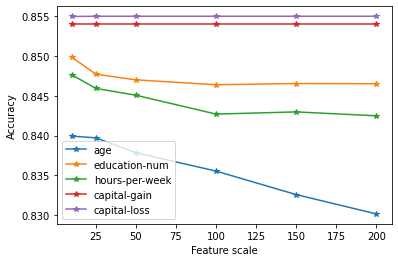

In [7]:
tools.plot_scaling_results(KNN_cross_val_scaled)

We can deduct from this that scaling has not brought any relevant value to our model's performance. Thus, we have decided not to apply any scaling to our model.

* ### 5-fold cross validation on that same data with the Decision Tree algorithm:

In [8]:
DT_cross_val = tools.l_fold_cross_validation_DT(L=5, X=X, Y=Y, criterion=["gini", "entropy"],splitter=["best","random"],max_depth=[10,20,30,40,50],min_impurity_decrease=[0.2,0.1,0.05,0.025,0.01,0],min_samples_leaf=[1,5,10,15,20,25])

0 %
20 %
40 %
60 %
80 %
Done
Performing 5-fold-cross-validation on  720  permutations of hyperparameters took  340.2424571  seconds


We will now try to find the best hyperparameters for our Decision Tree algorithm:

In [9]:
best_hp = DT_cross_val[DT_cross_val.accuracy == DT_cross_val.accuracy.max()]
# if we have a tie of best hyperparameters, choose the one with the fastest time
if best_hp.shape[0]>1:
    best_hp = best_hp[best_hp.time_req == best_hp.time_req.min()]
print("best hyperparmater values are: ")
best_hp

best hyperparmater values are: 


,criterion,splitter,max_depth,min_impurity_decrease,min_samples_leaf,accuracy,time_req
538,entropy,best,50,0.0,20,0.858876,1.063344


Looking at the above table, we can easily see which are the best parameters for our Decision Tree algorithm.

* ### L-fold cross validation with KNN algorithm on that same data with L > 5:

Now we want to run the same experiment but with larger subsets of the training validation data. Since this will be very time-consuming, we will run the cross_validation with a smaller range of hyperparameters

In [ ]:
for l in [10,15,20,25]:
    print("L = ", l)
    KNN_cross_val = tools.l_fold_cross_validation_KNN(L=l, X=X, Y=Y, K=[5,10,14,15])
    argmax = KNN_cross_val.argmax()
    print("the best accuracy = ", KNN_cross_val.max(), ", achieved for K = ", argmax+1)

We want to understand how the size of a dataset impacts both the training and validation error.
<br>We can see that as L increases, or more specifically when L > 5, setting K = 2 instead of 14 results in a better performance for our model. As for the accuracy, it has increased by 0.1%, which is not enough to deduct anything (this variation can be due to the finite size of the dataset).

* ### L-fold cross validation with the Decision Tree algorithm on that same data with L > 5:

As for the KNN algorithm, we will run the cross_validation with a smaller range of hyperparameters:

In [ ]:
for l in [10,15,20,25]:
    print("L = ", l)
    print('Loading... This might take a while')
    DT_cross_val = tools.l_fold_cross_validation_DT(L=l, X=X, Y=Y,criterion=["gini", "entropy"],splitter=["best","random"],max_depth=[10,15],min_impurity_decrease=[0.1,0.025,0],min_samples_leaf=[1,5,10,15,20,25])
    best_hp = DT_cross_val[DT_cross_val.accuracy == DT_cross_val.accuracy.max()]
    # if we have a tie of best hyperparameters, choose the one with the fastest time
    if best_hp.shape[0]>1:
        best_hp = best_hp[best_hp.time_req == best_hp.time_req.min()]
    print("The best hyperparmater values are:")
    display(best_hp)
    print()

We want to understand how the size of a dataset impacts both the training and validation error
<br>Looking at the above tables, we notice that as L increases, most hyperparameters that lead to optimal results are different than when L = 5 (Gini has been the better criterion over Entropy - maximum depth has decreased significantly ...), although the accuracy remains relatively unchanged. This means that we can manage to achieve the same accuracy as L increases by tweaking our hyperparameters as was seen in the tables.

### Applying our model on unseen data:

Now, let's check our performance on the test data. 
First, we have to load the test data, and perform the same cleaning as we did on the training data:

In [19]:
# load and clean test data

df_test = pd.read_csv("C:/Users/admin/Desktop/COMP 551/Assignments/COMP551_A1/adult.test", sep=",")
df_test.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
              'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
              'label']
df_test = df_test.drop(columns=['fnlwgt','education'])

# replacing all invalid entries by NaN
df_test = tools.clean_df(df_test)
labels = df_test.loc[:, 'label'].to_numpy() # array ot label string
df_test = df_test.iloc[:, 0:-1] # drop label in dataframe
# do label encoding on Y
le = preprocessing.LabelEncoder()
le.fit(labels)
#print("classes = ", le.classes_)
Y_test = le.transform(labels)


# select the columns with discrete variables
discrete_columns_selector = selector(dtype_include=object)
discrete_columns = discrete_columns_selector(df_test)
df_discrete = df_test[discrete_columns]


# replacing nan values with mode of respective column
for (column_name, column_data) in df_discrete.iteritems():
    mode = df_discrete[column_name].mode(dropna=True)[0]
    df_discrete[column_name] = df_discrete[column_name].fillna(mode)
    
    
# select the columns with continuous variables
continuous_columns_selector = selector(dtype_include = int)
continuous_columns = continuous_columns_selector(df_test)
df_continuous = df_test[continuous_columns]
df_continuous.reset_index(drop=True, inplace=True)


# replacing nan values with mean of respective column
for (column_name, column_data) in df_continuous.iteritems():
    mean = df_continuous[column_name].mean(skipna = True)
    df_continuous[column_name] = df_continuous[column_name].fillna(mean)
    

# do one hot encoding on dsicrete variables in dataframe
discrete_encoded = tools.oneHotEncoding(df_discrete)
discrete_encoded.reset_index(drop=True, inplace=True)

# merge the continuous and discrete and label features into one df
df_encoded_test = pd.concat([df_continuous,discrete_encoded],  axis=1, join='inner')

print(df_encoded_test.shape)



(16280, 87)


We notice the test data has less columns than the training data, so we need to fill the missing columns with 0.

In [24]:
# add missing column to training set
for i in range(len(df_encoded.columns)):
    if df_encoded.columns[i] != df_encoded_test.columns[i]:
        df_encoded_test.insert(loc=i, column=df_encoded.columns[i], value=[0]*df_encoded_test.shape[0])

X_test = df_encoded_test.to_numpy()


* ### KNN on unseen data:

We now run our KNN model on unseen data:

In [25]:
# KNN
for k in [2,14]:
    # see training data results on KNN using K=k
    KNN_classifier = KNN(n_neighbors=k)
    KNN_classifier.fit(X, Y) # fit the model using training data
    Y_prediction = KNN_classifier.predict(X_test) # predict test data
    accuracy = Y_prediction == Y_test
    accuracy = np.sum(accuracy)  # number of correct predictions
    score = accuracy / X_test.shape[0]  # ratio of correct prediction
    print("for k = ", k, "the accuracy on the test data is: ", score)

for k =  2 the accuracy on the test data is:  0.8445945945945946
for k =  14 the accuracy on the test data is:  0.8582923832923833


Just out of curiousity, we have also tested our model for K = 2 (which was the best performing value for when L > 5). 
<br>Otherwise, assuming our model performs best when K = 14, we can estimate an accuracy of 85.83% on unseen data with our KNN model.

* ### Decision Tree algorithm on unseen data:

Using the best hyperparameters for our model when L = 5, we run our Decision Tree algorithm on unseen data:

In [26]:
# DT
# predict on test data using best hyperparameters
DT_classifier = DT(criterion="entropy", splitter="best", max_depth=50,
                min_impurity_decrease=0, min_samples_leaf=20)
DT_classifier.fit(X, Y)
Y_prediction = DT_classifier.predict(X_test)
accuracy = Y_prediction == Y_test
accuracy = np.sum(accuracy)  # number of correct predictions
score = accuracy/X_test.shape[0]
print("For the best hyperparameters, the accuracy is: ", score)

For the best hyperparameters, the accuracy is:  0.8636363636363636


<br>Assuming our model performs best under these parameters, we can estimate an accuracy of 86.36% on unseen data with our Decision Tree model.

<br>
<br>
<br>
<br>

## Dataset 2 : balance-scale

For the second part of the project, we begin our analysis on the data set we have chosen: balance-scale. 
<br>Most of our helper functions can be found in the ***tools.py*** file.
<br>We start by importing the dataset and storing the equivalent data in Pandas Dataframes:

Now, we try cleaning our data by dropping irrelevant features that could obstruct the performance of our model:

In [114]:
import pandas as pd
import numpy as np
import random
import tools
from sklearn.compose import make_column_selector as selector
from sklearn import preprocessing
from sklearn.preprocessing import normalize
import warnings
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
import sklearn

warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

df2 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data", sep=",")
df2.columns = ['Class', 'Left-Weight', 'Left-Distance', 'Right-Weight', 'Right-Distance']
df2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Class,Left-Weight,Left-Distance,Right-Weight,Right-Distance
0,R,1,1,1,2
1,R,1,1,1,3
2,R,1,1,1,4
3,R,1,1,1,5
4,R,1,1,2,1
...,...,...,...,...,...
619,L,5,5,5,1
620,L,5,5,5,2
621,L,5,5,5,3
622,L,5,5,5,4


The dataset we have chosen contains no missing values, hence we do not need to perform any data imputation. Also, all the features in the dataset are very relevant to our use-case which means we do not need to drop any potentially noisy feature.
<br>Firstly, we will have to encode our 'Class' column by mapping each of the 3 possible values to an integer.
<br>After that, we will need to seperate our dataset into a training set and a test set, and will do respectively using 2/3 and 1/3 as the proportions relative to the size of the set (the number of rows). These proportions are purely arbitrary, and were chosen as such because of popularity (another common ratio is 80:20 for the training-test sets).

In [131]:
split_index = round(df2.shape[0]*(2/3))
df2_test = df2.iloc[split_index:, :]
df2_train = df2.iloc[:split_index, :]

labels2 = df2_train.loc[:, 'Class'].to_numpy() # array to label string
labels2_test = df2_test.loc[:, 'Class'].to_numpy() # array to label string
df2_train = df2_train.iloc[:, 1:] # drop label in dataframe
df2_test = df2_test.iloc[:, 1:] # drop label in dataframe

# do label encoding on Ys
le2 = preprocessing.LabelEncoder()
le2.fit(labels2)

Y2 = le2.transform(labels2)
X2 = df2_train.to_numpy()

Y2_test = le2.transform(labels2_test)
X2_test = df2_test.to_numpy()

* ### 5-fold cross validation with the KNN algorithm:
Now, we run the 5-fold cross validation on the encoded data frame with the KNN algorithm, with K ranging from 1 to 20:

In [132]:
KNN_cross_val = tools.l_fold_cross_validation_KNN(L=5, X=X2, Y=Y2, K=[k for k in range(1,21)])
columns2 = ["k=" + str(i) for i in range(1,21)]
KNN_cross_val_results = pd.DataFrame(columns=columns2)
KNN_cross_val_results.loc[0]=KNN_cross_val
KNN_cross_val_results

0 %
20 %
40 %
60 %
80 %


,k=1,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,k=10,k=11,k=12,k=13,k=14,k=15,k=16,k=17,k=18,k=19,k=20
0,0.761446,0.693976,0.780723,0.790361,0.819277,0.814458,0.831325,0.836145,0.831325,0.840964,0.836145,0.840964,0.845783,0.838554,0.840964,0.838554,0.836145,0.840964,0.838554,0.828916


We now analyze our results for different values of K:

In [133]:
argmax = KNN_cross_val.argmax()
print("best accuracy =", KNN_cross_val.max(), ", achieved for K = ", argmax+1)

best accuracy =  0.8457831325301205 , achieved for K =  13


Given the previous results, we can deduct that before scaling, the best performing KNN model was the one where K is 13.

Due to computational complexity, we will assume that our model performs performs best when K=13 even when we add feature scaling to it (instead of testing out all combinations of feature scaling for all possible K values). Since our dataset only contains 4 features, we have decided to alter our model by scaling all of them.
<br>In order to determine when our model performs best, we wrote a function that tests it out for different scales for each relevant feature:

In [134]:
X_scaling = df2_train
scalable_features = ('Left-Weight', 'Left-Distance', 'Right-Weight', 'Right-Distance')
KNN_cross_val_scaled2 = tools.l_fold_cross_validation_KNN_scaling_test(L=5, X=X_scaling, Y=Y2, K=13, scalable_features=scalable_features)

Now scaling Left-Weight by 10
Now scaling Left-Weight by 25
Now scaling Left-Weight by 50
Now scaling Left-Weight by 100
Now scaling Left-Weight by 150
Now scaling Left-Weight by 200
Now scaling Left-Distance by 10
Now scaling Left-Distance by 25
Now scaling Left-Distance by 50
Now scaling Left-Distance by 100
Now scaling Left-Distance by 150
Now scaling Left-Distance by 200
Now scaling Right-Weight by 10
Now scaling Right-Weight by 25
Now scaling Right-Weight by 50
Now scaling Right-Weight by 100
Now scaling Right-Weight by 150
Now scaling Right-Weight by 200
Now scaling Right-Distance by 10
Now scaling Right-Distance by 25
Now scaling Right-Distance by 50
Now scaling Right-Distance by 100
Now scaling Right-Distance by 150
Now scaling Right-Distance by 200


Let's visualize the results of our test:

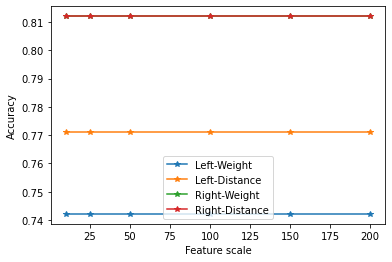

In [136]:
tools.plot_scaling_results(KNN_cross_val_scaled2)

We can deduct from this that scaling has not brought any change whatsoever to our model's performance. Thus, we have decided not to apply any scaling to our model.

* ### 5-fold cross validation on that same data with the Decision Tree algorithm:

In [137]:
DT_cross_val2 = tools.l_fold_cross_validation_DT(L=5, X=X2, Y=Y2, criterion=["gini", "entropy"],splitter=["best","random"],max_depth=[10,20,30,40,50],min_impurity_decrease=[0.2,0.1,0.05,0.025,0.01,0],min_samples_leaf=[1,5,10,15,20,25])

0 %
20 %
40 %
60 %
80 %
Done
Performing 5-fold-cross-validation on  720  permutations of hyperparameters took  3.948081624999759  seconds


We will now try to find the best hyperparameters for our Decision Tree algorithm:

In [139]:
best_hp2 = DT_cross_val2[DT_cross_val2.accuracy == DT_cross_val2.accuracy.max()]
# if we have a tie of best hyperparameters, choose the one with the fastest time
if best_hp2.shape[0]>1:
    best_hp2 = best_hp2[best_hp2.time_req == best_hp2.time_req.min()]
print("best hyperparmater values are: ")
best_hp2

best hyperparmater values are: 


,criterion,splitter,max_depth,min_impurity_decrease,min_samples_leaf,accuracy,time_req
463,entropy,best,30,0.0,5,0.768675,0.001674


Looking at the above table, we can easily see which are the best parameters for our Decision Tree algorithm.

* ### L-fold cross validation with KNN algorithm on that same data with L > 5:

Now we want to run the same experiment but with larger subsets of the training validation data. Since this will be very time-consuming, we will run the cross_validation with a smaller range of hyperparameters

In [140]:
for l in [10,15,20,25,30,35,40]:
    print("L = ", l)
    KNN_cross_val2 = tools.l_fold_cross_validation_KNN(L=l, X=X2, Y=Y2, K=[5,10,11,15])
    argmax = KNN_cross_val2.argmax()
    print("The best accuracy = ", KNN_cross_val2.max(), ", achieved for K = ", argmax+1)

L =  10
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
The best accuracy =  0.8243902439024391 , achieved for K =  2
L =  15
0 %
6 %
13 %
20 %
26 %
33 %
40 %
46 %
53 %
60 %
66 %
73 %
80 %
86 %
93 %
The best accuracy =  0.8419753086419753 , achieved for K =  1
L =  20
0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
The best accuracy =  0.8300000000000003 , achieved for K =  2
L =  25
0 %
4 %
8 %
12 %
16 %
20 %
24 %
28 %
32 %
36 %
40 %
44 %
48 %
52 %
56 %
60 %
64 %
68 %
72 %
76 %
80 %
84 %
88 %
92 %
96 %
The best accuracy =  0.845 , achieved for K =  1
L =  30
0 %
3 %
6 %
10 %
13 %
16 %
20 %
23 %
26 %
30 %
33 %
36 %
40 %
43 %
46 %
50 %
53 %
56 %
60 %
63 %
66 %
70 %
73 %
76 %
80 %
83 %
86 %
90 %
93 %
96 %
The best accuracy =  0.8410256410256413 , achieved for K =  2
L =  35
0 %
2 %
5 %
8 %
11 %
14 %
17 %
20 %
22 %
25 %
28 %
31 %
34 %
37 %
40 %
42 %
45 %
48 %
51 %
54 %
57 %
60 %
62 %
65 %
68 %
71 %
74 %
77 %
80 %
82 %
85 %
88 %
91 %
94 %


We want to understand how the size of a dataset impacts both the training and validation error.
<br>We can see that as L increases, or more specifically when L > 5, K seems to be stabilising around 2 as it's best value, which is low when compared to our previous best value when L = 5, 13.
<br>However, the accuracy seems to be relatively unchanged when compared to the previous accuracy we achieved when using 5-fol cross-validation.

* ### L-fold cross validation with the Decision Tree algorithm on that same data with L > 5:

As for the KNN algorithm, we will run the cross_validation with a smaller range of hyperparameters:

In [141]:
for l in [10,15,20,25,30,35,40]:
    print("L = ", l)
    DT_cross_val2 = tools.l_fold_cross_validation_DT(L=l, X=X2, Y=Y2,criterion=["gini", "entropy"],splitter=["best","random"],max_depth=[10,15],min_impurity_decrease=[0.1,0.025,0],min_samples_leaf=[1,5,10,15,20,25])
    best_hp2 = DT_cross_val2[DT_cross_val2.accuracy == DT_cross_val2.accuracy.max()]
    # if we have a tie of best hyperparameters, choose the one with the fastest time
    if best_hp2.shape[0]>1:
        best_hp2 = best_hp2[best_hp2.time_req == best_hp2.time_req.min()]
    print("The best hyperparmater values are:")
    display(best_hp2)
    print()

L =  10
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Done
Performing 10-fold-cross-validation on  144  permutations of hyperparameters took  1.345486540998536  seconds
The best hyperparmater values are:


,criterion,splitter,max_depth,min_impurity_decrease,min_samples_leaf,accuracy,time_req
138,entropy,random,15,0.0,1,0.780488,0.003429



L =  15
0 %
6 %
13 %
20 %
26 %
33 %
40 %
46 %
53 %
60 %
66 %
73 %
80 %
86 %
93 %
Done
Performing 15-fold-cross-validation on  144  permutations of hyperparameters took  1.9023771250031132  seconds
The best hyperparmater values are:


,criterion,splitter,max_depth,min_impurity_decrease,min_samples_leaf,accuracy,time_req
139,entropy,random,15,0.0,5,0.790123,0.004271



L =  20
0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
Done
Performing 20-fold-cross-validation on  144  permutations of hyperparameters took  2.526824749998923  seconds
The best hyperparmater values are:


,criterion,splitter,max_depth,min_impurity_decrease,min_samples_leaf,accuracy,time_req
103,entropy,best,15,0.0,5,0.7925,0.006629



L =  25
0 %
4 %
8 %
12 %
16 %
20 %
24 %
28 %
32 %
36 %
40 %
44 %
48 %
52 %
56 %
60 %
64 %
68 %
72 %
76 %
80 %
84 %
88 %
92 %
96 %
Done
Performing 25-fold-cross-validation on  144  permutations of hyperparameters took  3.1227833750017453  seconds
The best hyperparmater values are:


,criterion,splitter,max_depth,min_impurity_decrease,min_samples_leaf,accuracy,time_req
102,entropy,best,15,0.0,1,0.795,0.0102



L =  30
0 %
3 %
6 %
10 %
13 %
16 %
20 %
23 %
26 %
30 %
33 %
36 %
40 %
43 %
46 %
50 %
53 %
56 %
60 %
63 %
66 %
70 %
73 %
76 %
80 %
83 %
86 %
90 %
93 %
96 %
Done
Performing 30-fold-cross-validation on  144  permutations of hyperparameters took  3.6685095409993664  seconds
The best hyperparmater values are:


,criterion,splitter,max_depth,min_impurity_decrease,min_samples_leaf,accuracy,time_req
14,gini,best,10,0.0,10,0.787179,0.00912



L =  35
0 %
2 %
5 %
8 %
11 %
14 %
17 %
20 %
22 %
25 %
28 %
31 %
34 %
37 %
40 %
42 %
45 %
48 %
51 %
54 %
57 %
60 %
62 %
65 %
68 %
71 %
74 %
77 %
80 %
82 %
85 %
88 %
91 %
94 %
97 %
Done
Performing 35-fold-cross-validation on  144  permutations of hyperparameters took  4.246664791000512  seconds
The best hyperparmater values are:


,criterion,splitter,max_depth,min_impurity_decrease,min_samples_leaf,accuracy,time_req
102,entropy,best,15,0.0,1,0.784416,0.013869



L =  40
0 %
2 %
5 %
7 %
10 %
12 %
15 %
17 %
20 %
22 %
25 %
27 %
30 %
32 %
35 %
37 %
40 %
42 %
45 %
47 %
50 %
52 %
55 %
57 %
60 %
62 %
65 %
67 %
70 %
72 %
75 %
77 %
80 %
82 %
85 %
87 %
90 %
92 %
95 %
97 %
Done
Performing 40-fold-cross-validation on  144  permutations of hyperparameters took  4.804851332999533  seconds
The best hyperparmater values are:


,criterion,splitter,max_depth,min_impurity_decrease,min_samples_leaf,accuracy,time_req
86,entropy,best,10,0.0,10,0.8125,0.0123


We want to understand how the size of a dataset impacts both the training and validation error
<br>Looking at the above tables, we notice that as L increases, some hyperparameters that lead to optimal results are different than when L = 5 (Maximum depth has decreased significantly from 30 to about 10-15,  ...). As for the accuracy, it increases a bit (~2.1% on average when L > 5) although this doesn't necessarily imply a correlation between the two.

### Applying our model on unseen data:

Now, let's check our performance on the test data. Unlike our first dataset where the test data was located in a seperate file, in this case we have already split the data into train set and test set. Thus, we can jump right into it:

* ### KNN on unseen data:

We now run our KNN model on unseen data using the optimal K we have found earlier (13):

In [160]:
# KNN
# see training data results on KNN using K=13
KNN_classifier2 = KNN(n_neighbors=13)
KNN_classifier2.fit(X2, Y2) # fit the model using training data
Y_prediction2 = KNN_classifier2.predict(X2_test) # predict test data
accuracy2 = Y_prediction2 == Y2_test
accuracy2 = np.sum(accuracy2)  # number of correct predictions
score2 = accuracy2 / X2_test.shape[0]  # ratio of correct prediction
print("For k = ", k, "the accuracy on the test data is: ", score2)

For k =  13 the accuracy on the test data is:  0.3605769230769231


Based on those results, we can estimate an accuracy of 36.06% on unseen data with our KNN model.

* ### Decision Tree algorithm on unseen data:

Using the best hyperparameters for our model when L = 5, we run our Decision Tree algorithm on unseen data:

In [159]:
# DT
# predict on test data using best hyperparameters
DT_classifier2 = DT(criterion="entropy", splitter="best", max_depth=30,
                min_impurity_decrease=0, min_samples_leaf=5)
DT_classifier2.fit(X2, Y2)
Y_prediction2 = DT_classifier2.predict(X2_test)
accuracy2 = Y_prediction2 == Y2_test
accuracy2 = np.sum(accuracy2)  # number of correct predictions
score2 = accuracy2/X2_test.shape[0]
print("For the best hyperparameters, the accuracy is: ", score2)

For the best hyperparameters, the accuracy is:  0.46634615384615385


<br>Assuming our model performs best under these parameters, we can estimate an accuracy of 46.63% on unseen data with our Decision Tree model.